# はじめに

このノートでは、lightGBMのアルゴリズムに関して、基本的な部分をおさらいして、まとめている。下記の書籍のコードと論文を参考にしている。

- [LightGBM予測モデル実装ハンドブック](https://www.shuwasystem.co.jp/book/9784798067612.html)
- [LightGBM: A Highly Efficient Gradient Boosting Decision Tree](https://proceedings.neurips.cc/paper_files/paper/2017/file/6449f44a102fde848669bdd9eb6b76fa-Paper.pdf)

今回はモデル解釈をPythonでどのように行うかに焦点をあてているので、数理の部分は扱っておらず、モデル学習の部分に関しても、まとめて実行している。

## モデルの学習

必要なライブラリをインポートしておく。今回はモデル解釈に焦点をあてているので、モデル学習の部分はまとめて実行しておく。

In [1]:
%matplotlib inline
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import lightgbm as lgb
import graphviz
import shap

from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error

ここで使用するデータは、ボストン市の住宅価格に関するサンプルデータ。データの説明は下記の通り。

|変数|説明|
|:---|:---|
|`CRIM`	|人口1人当たりの犯罪発生数|
|`ZN`|25,000平方フィート以上の住居区画の占める割合|
|`INDUS`|小売業以外の商業が占める面積の割合|
|`CHAS`|チャールズ川によるダミー変数 (1: 川の周辺, 0: それ以外)|
|`NOX`|NOx の濃度|
|`RM`|住居の平均部屋数|
|`AGE`|1940 年より前に建てられた物件の割合|
|`DIS`|5つのボストン市の雇用施設からの距離|
|`RAD`|高速道路へのアクセスしやすさ|
|`TAX`|$10,000 ドルあたりの不動産税率の総計|
|`PTRATIO`|町毎の児童と教師の比率|
|`B`|町毎の黒人 (Bk) の比率を次の式で表したもの。 1000(Bk – 0.63)^2|
|`LSTAT`|	給与の低い職業に従事する人口の割合 (%)|
|`MEDV`|	所有者が占有している家屋の$ 1000単位の中央値。24という表記だと24000ドル。|


In [2]:
# データセットの読み込み
df = pd.read_csv('https://archive.ics.uci.edu/ml/machine-learning-databases/housing/housing.data', header=None, sep='\s+')
df.columns=['CRIM', 'ZN', 'INDUS', 'CHAS', 'NOX', 'RM', 'AGE', 'DIS', 'RAD', 'TAX', 'PTRATIO', 'B', 'LSTAT', 'MEDV']
df.head()

,CRIM,ZN,INDUS,CHAS,NOX,RM,AGE,DIS,RAD,TAX,PTRATIO,B,LSTAT,MEDV
0,0.00632,18.0,2.31,0,0.538,6.575,65.2,4.0900,1,296.0,15.3,396.90,4.98,24.0
1,0.02731,0.0,7.07,0,0.469,6.421,78.9,4.9671,2,242.0,17.8,396.90,9.14,21.6
2,0.02729,0.0,7.07,0,0.469,7.185,61.1,4.9671,2,242.0,17.8,392.83,4.03,34.7
3,0.03237,0.0,2.18,0,0.458,6.998,45.8,6.0622,3,222.0,18.7,394.63,2.94,33.4
4,0.06905,0.0,2.18,0,0.458,7.147,54.2,6.0622,3,222.0,18.7,396.90,5.33,36.2


目的変数は、所有者が占有している家屋の$1000単位の中央値`MEDV`で、24という表記だと24000ドルを意味する。特徴量は`MEDV`以外とする。また、予測値の計算過程を理解するためにデータ分割は簡単にしておく。

|パラメタ名|説明|
|:---|:---|
|`objective`|	損失関数の種類|
|`metric`|	`objective`と異なる評価指標を使用する場合に利用|
|`learning_rate`|学習率。1回のブースティングで加算する重みの比率。|
|`num_leaves`|モデルが持つ葉の最大値|
|`max_depth`|決定木の深さの上限|
|`min_data_in_leaf`|葉の作成に必要な最小のサンプル数|
|`max_bin`|ヒストグラムのbinの件数の最大値|
|`min_data_in_bin`|ヒストグラムの1つのbinに含まれる最小のサンプル数|
|`n_estimators`|決定木の数|
|`verbose`|学習プロセスの詳細を表示するかどうかを制御|
|`early_stopping_rounds`|	学習を重ねても評価指標が改善しなくなった場合の停止するときの回数|


In [3]:
# 特徴量と目的変数の設定
X = df.drop(['MEDV'], axis=1)
y = df['MEDV']

# 学習データとテストデータに分割
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, shuffle=True, random_state=0)
print('X_trainの形状：', X_train.shape, ' y_trainの形状：', y_train.shape, ' X_testの形状：', X_test.shape, ' y_testの形状：', y_test.shape)
print('-------------------------------------------------')
# ハイパーパラメータの設定
lgb_train = lgb.Dataset(X_train, y_train)

params = {'objective': 'mse',
          'num_leaves': 5,
          'seed': 0,
          'verbose': -1,
}

# モデルの学習
model = lgb.train(params,
                  lgb_train,
                  num_boost_round=50,
                  valid_sets=[lgb_train],
                  valid_names=['train'],
                  callbacks=[lgb.log_evaluation(10)])
print('-------------------------------------------------')
# 学習データの予測と評価
y_train_pred = model.predict(X_train) 
print('MSE train: %.2f' % (mean_squared_error(y_train, y_train_pred)))
print('RMSE train: %.2f' % (mean_squared_error(y_train, y_train_pred) ** 0.5))
print('-------------------------------------------------')
# テストデータの予測と評価
y_test_pred = model.predict(X_test)
print('MSE test: %.2f' % (mean_squared_error(y_test, y_test_pred)))
print('RMSE test: %.2f' % (mean_squared_error(y_test, y_test_pred) ** 0.5))

X_trainの形状： (404, 13)  y_trainの形状： (404,)  X_testの形状： (102, 13)  y_testの形状： (102,)
-------------------------------------------------
[10]	train's l2: 23.2264
[20]	train's l2: 11.4353
[30]	train's l2: 8.26905
[40]	train's l2: 6.83309
[50]	train's l2: 5.88687
-------------------------------------------------
MSE train: 5.89
RMSE train: 2.43
-------------------------------------------------
MSE test: 24.66
RMSE test: 4.97


## モデル解釈
### 変数重要度

ランダムフォレストやXGBoostと同様に変数重要度やSHAPが計算できる。`gain`は分割時に誤差が大きく減少するかを基準とする設定。このモデルでは、給与の低い職業に従事する人口の割合(%)`LSTST`と住居の平均部屋数`RM`が重要となっている。これは、真のモデルにおいて重要という意味ではなく、今回のモデルで予測をする上で重要という意味。

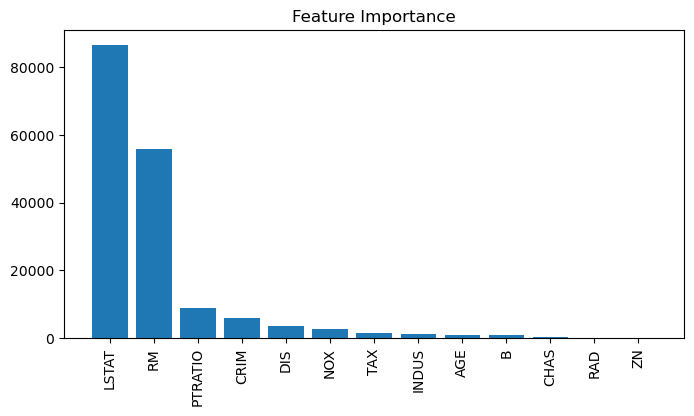

In [4]:
# 特徴量の重要度の可視化
importances = model.feature_importance(importance_type='gain') # 特徴量の重要度
indices = np.argsort(importances)[::-1] # 特徴量の重要度を降順にソート

plt.figure(figsize=(8, 4)) #プロットのサイズ指定
plt.title('Feature Importance') # プロットのタイトルを作成
plt.bar(range(len(indices)), importances[indices]) # 棒グラフを追加
plt.xticks(range(len(indices)), X.columns[indices], rotation=90) # X軸に特徴量の名前を追加
plt.show() # プロットを表示

### 木の可視化

変数重要度では、各特徴量の分割点はわからないため、分割点を知りたければ、木を可視化する必要がある。ただ、ブースティングの回数分、木を可視化できるため、木の可視化から統一的な情報を引き出すのは難しいかもしれない。

<Axes: >

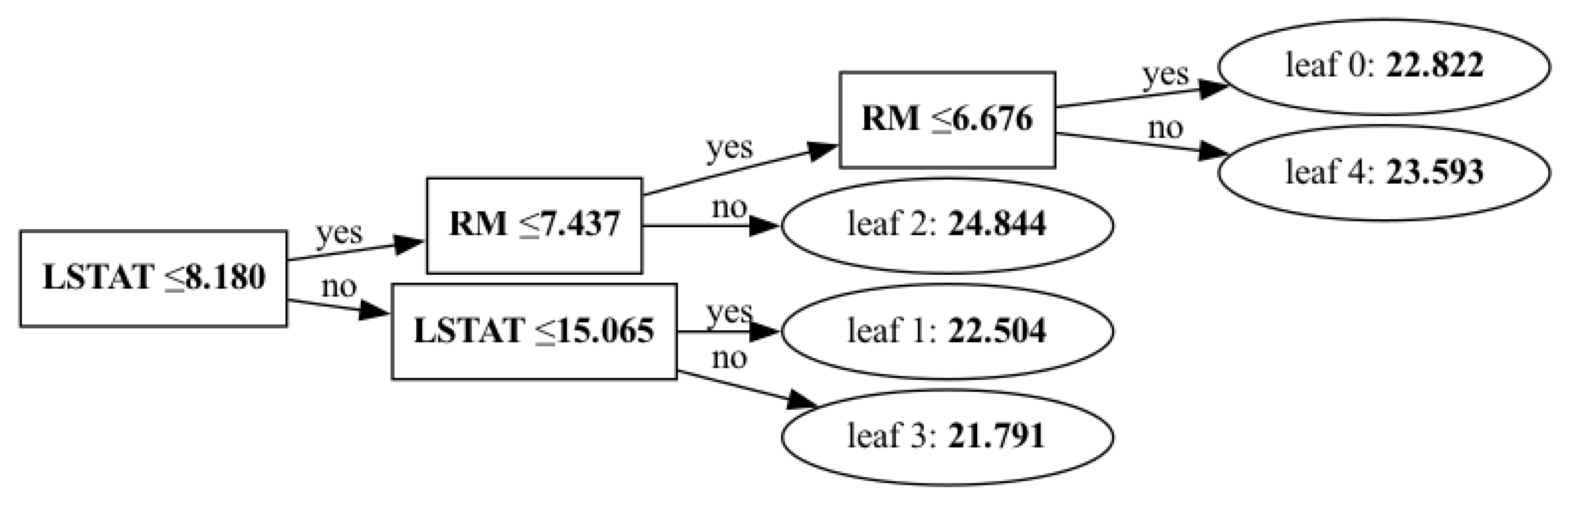

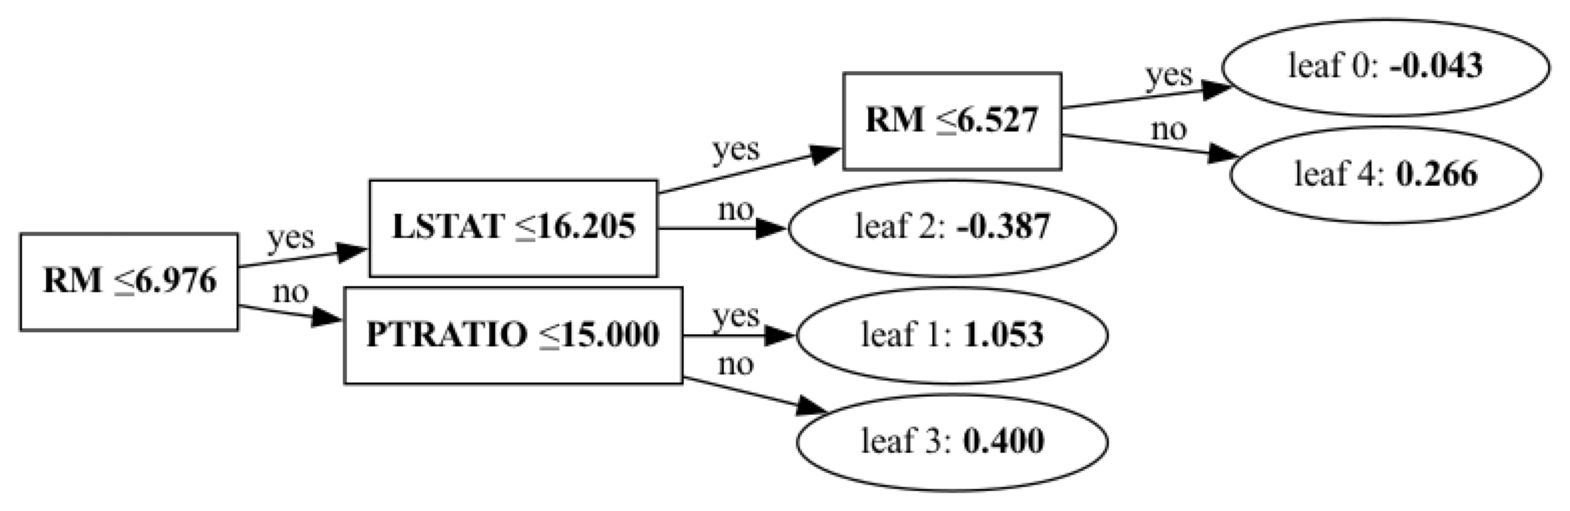

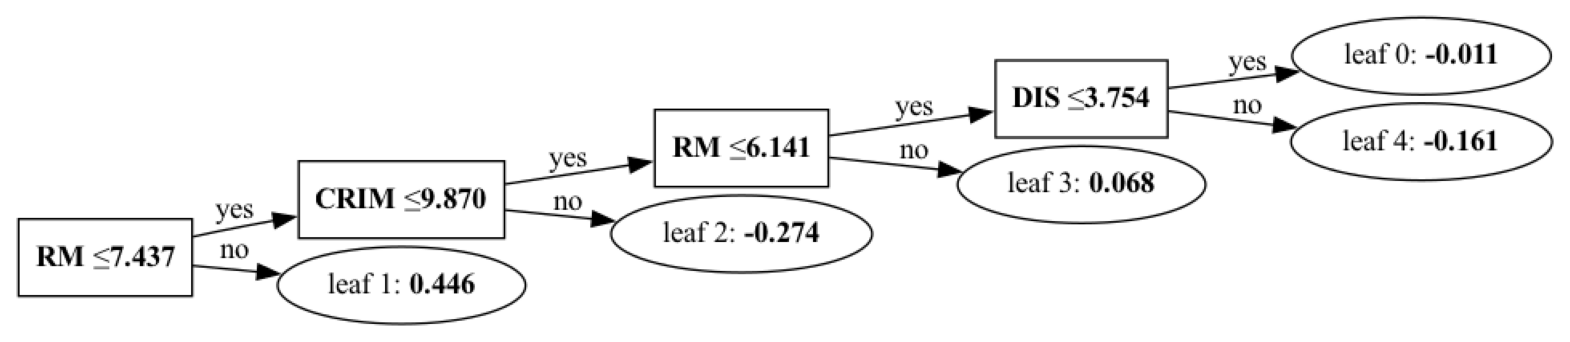

In [5]:
# 1本目の木の可視化
lgb.plot_tree(model, tree_index=0, figsize=(20, 20))
lgb.plot_tree(model, tree_index=9, figsize=(20, 20))
lgb.plot_tree(model, tree_index=19, figsize=(20, 20))

### SHAP

SHAPは、ゲーム理論にもとづいてモデルを解釈する手法のこと。まずは、`shap.TreeExplainer()`を使って、explainerの作成する。そして、shap値を計算する。shap値は入力データと同じサイズで返される。そのため、ここでは学習データを渡しているので、学習データと同じサイズで返されている。

In [6]:
# explainerの作成
explainer = shap.TreeExplainer(
    model = model,
    data = X_train,
    feature_pertubation = 'interventional'
    )

# SHAP値の計算
x_train_shap_values = explainer.shap_values(X_train)
x_train_shap_values.shape

(404, 13)

返された値は、行方向は「予測における各特徴量の貢献度」、列方向は「予測における、その特徴量の貢献度」を表している。数値を眺めても、解釈するのは難しいので、可視化する。

In [7]:
pd.DataFrame(x_train_shap_values)

,0,1,2,3,4,5,6,7,8,9,10,11,12
0,0.103316,0.0,-0.092827,0.578910,0.418933,2.188509,0.071921,0.398730,0.102782,-0.170299,0.982600,0.139548,0.246458
1,0.097723,0.0,-0.096529,-0.031250,0.382948,-1.839004,0.087319,-0.177998,-0.078203,-0.196388,0.035741,-0.026592,0.254716
2,0.164207,0.0,-0.080434,-0.031250,0.397039,1.915832,0.071179,-0.345918,0.069087,-0.190894,0.863960,0.103547,-1.239960
3,0.151404,0.0,-0.092827,-0.025844,0.416974,-1.831212,0.086835,-0.079092,0.095409,-0.177739,0.984130,0.116079,-0.793727
4,-1.314938,0.0,-0.097418,-0.019553,-1.786989,-1.526672,-0.053097,-0.100472,0.053984,-0.141454,-1.518314,-0.751572,-6.045463
...,...,...,...,...,...,...,...,...,...,...,...,...,...
399,0.132558,0.0,-0.098583,-0.031250,0.413253,-1.707121,-0.207346,-0.075107,0.095409,-0.033536,-0.352192,0.088705,-0.726823
400,0.038836,0.0,0.077261,-0.025844,0.358051,4.206015,0.010189,-0.635578,0.071010,-0.187099,1.144417,0.125825,9.081644
401,0.134675,0.0,-0.092827,-0.031250,0.427150,-1.655882,-0.219539,0.508859,0.102782,-0.194105,0.445670,0.083138,-0.850100
402,0.169091,0.0,-0.205878,-0.031250,0.547619,-1.843391,-0.182241,-0.030276,-0.078203,0.000163,0.518921,0.088705,-3.426770


一般的に使用される下記の可視化は正直、初見ではよくわからない。横軸が目的変数の値への貢献の大小を表し、縦軸が特徴量の貢献度の高さを表している。赤色が正の値、青色が負の値を表している。このモデルの目的変数は住宅価格なので、給与の低い職業に従事する人口の割合(%)`LSTAT`が高くなる(赤くなる、左)と、住宅価格は下がる。住居の部屋数`RM`だと、部屋数が多くなる(赤くなる、右)住宅価格は高くなる。上から順にみていき、特徴量が大きくなる=赤くなるときに、目的変数にポジティブ(ネガティブ)な影響なのかを見れば良い。

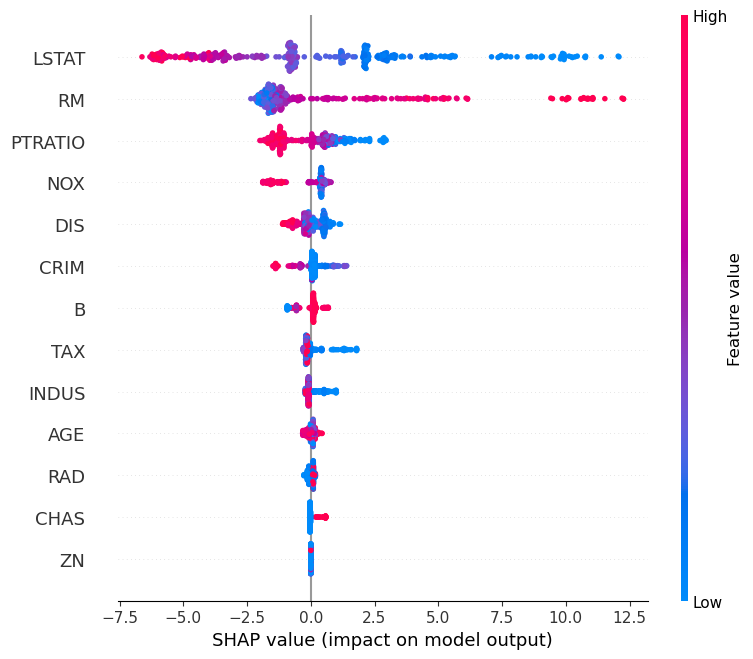

In [8]:
shap.summary_plot(shap_values=x_train_shap_values, features=X_train)

`plot_type`で`bar`を指定すれば変数重要度を可視化できる。

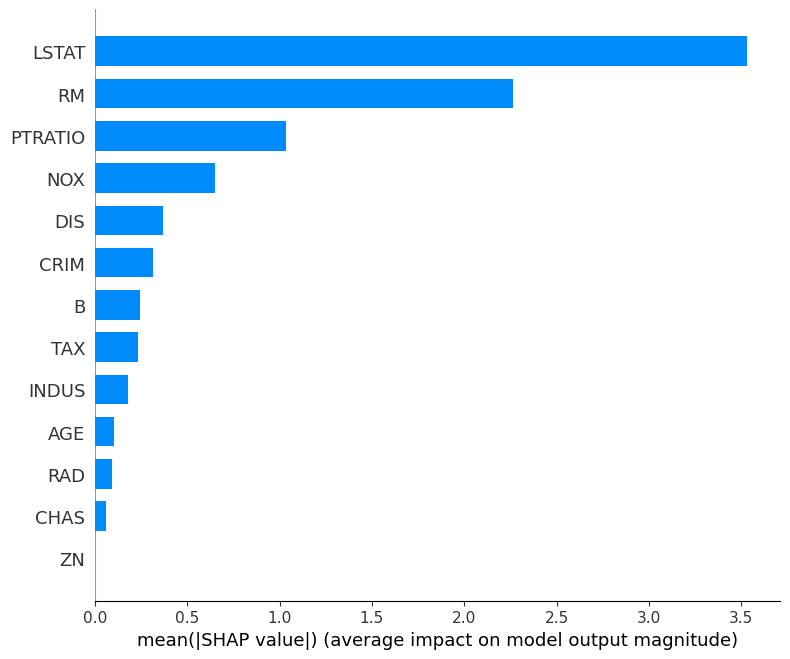

In [9]:
shap.summary_plot(x_train_shap_values, X_train, plot_type="bar")

次は部分従属性プロット。各特徴量と目的変数との関係を表しており、各特徴量の値に応じたSHAP値が可視化されている。このケースでは、目的変数の値ではなくSHAP値との関係になるので注意。例えば、`LSTAT`を例にすると、`LSTAT`の値が高くなると(=低所得者の割合が高くなる)、住宅価格に対して、マイナスの影響があることがわかる。

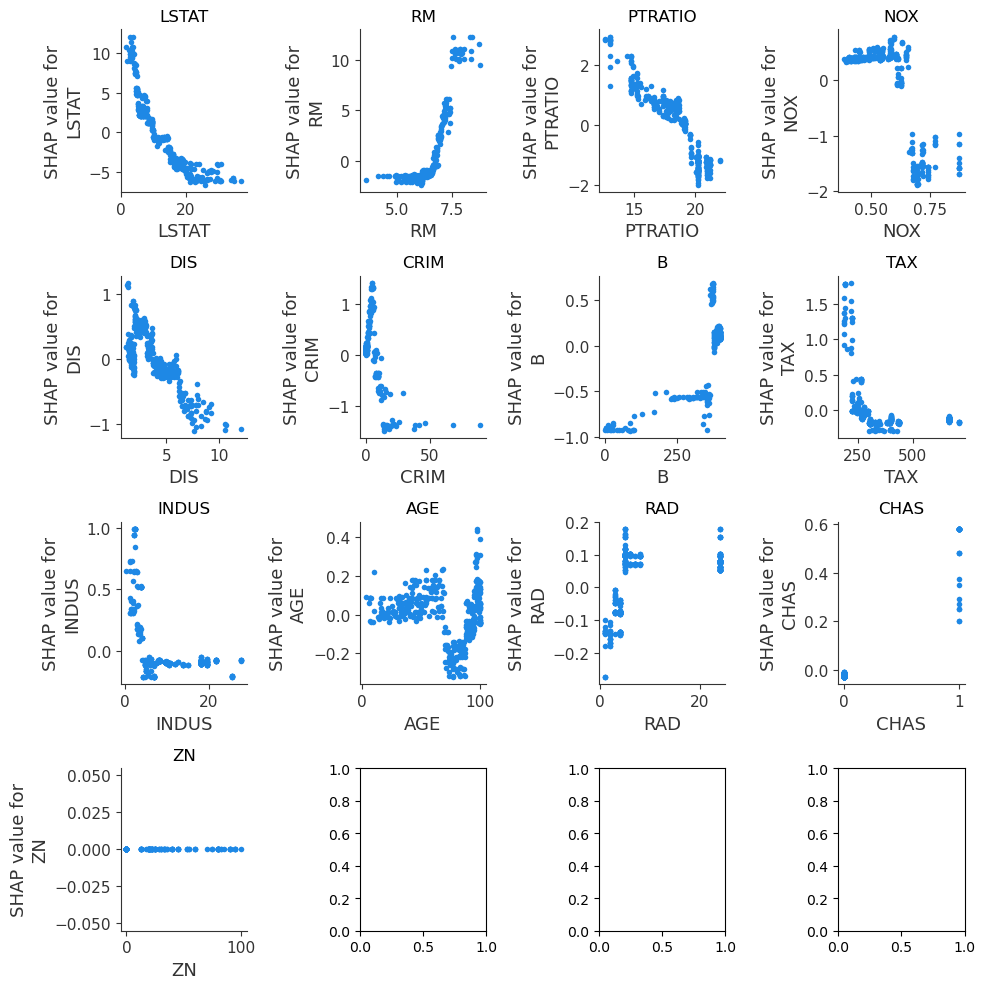

In [10]:
# サブプロットの準備
fig, axes = plt.subplots(4, 4, figsize=(10, 10))

# 重要度順で並び替える
sorted_col = X_train.columns[np.argsort(-np.abs(x_train_shap_values).mean(axis=0))]

# 各特徴量に対してSHAP値を可視化
for i, feature in enumerate(sorted_col):
    row = i // 4
    col = i % 4
    shap.dependence_plot(
        ind=feature, 
        interaction_index=None, 
        shap_values=x_train_shap_values, 
        features=X_train,
        ax=axes[row, col],
        show=False
    )
    axes[row, col].set_title(feature)

plt.tight_layout()
plt.show()

1つのデータに対する予測結果の解釈を得るためには、モデルを用いて`shap.force_plot()`を実行する。

この図は、モデルの予測値27.41を計算する際の各特徴量の貢献度合いを表す。予測値を大きくするのに貢献した特徴量は赤色、値を小さくするのに貢献した特徴は青色で表される。例えば、変数重要度では、`LSTAT`と`RM`が重要とされていたが、このケースでは`LSTAT`よりも`RM`のほうが貢献度合いが大きい。`LSTAT=9.71`は、このレコードの値であって、貢献度合いではないので注意。

In [11]:
# y_train_pred[0]: 27.412845443331662
# X_train.iloc[0,:]
# CRIM         0.35809
# ZN           0.00000
# INDUS        6.20000
# CHAS         1.00000
# NOX          0.50700
# RM           6.95100
# AGE         88.50000
# DIS          2.86170
# RAD          8.00000
# TAX        307.00000
# PTRATIO     17.40000
# B          391.70000
# LSTAT        9.71000
shap.force_plot(explainer.expected_value, x_train_shap_values[0,:], X_train.iloc[0,:])

これでは貢献度合いが数値で把握しにくいので、ウォーターフォールチャートで可視化したほうがわかりよい。ただ、パッケージのバージョンの関係で、1つのレコードに絞ってSHAP値を計算する必要があるっぽい。

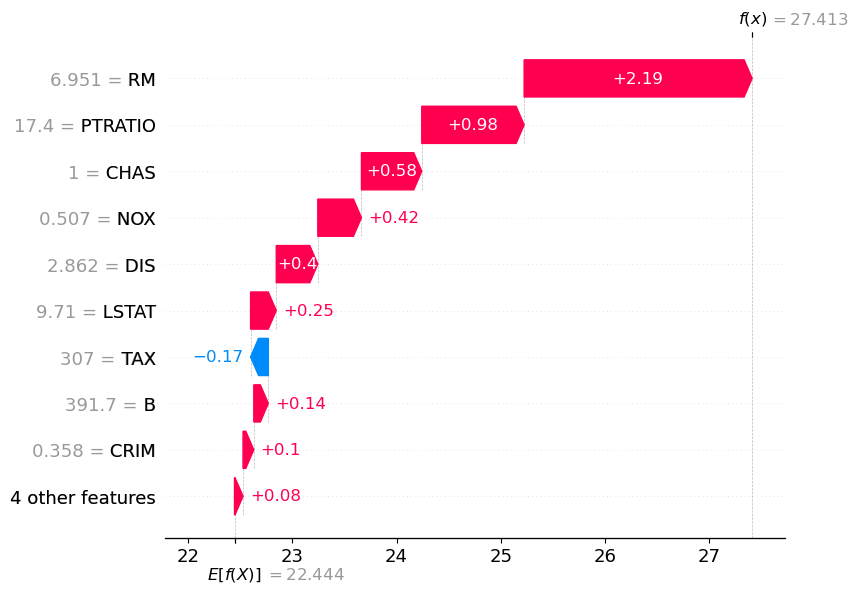

In [12]:
single_observation = X_train.iloc[0:1,:]
single_shap_values = explainer(single_observation)
shap.waterfall_plot(single_shap_values[0])

ウォーターフォールチャートの全体版のようなものも用意されている。各特徴量の平均の組み合わせによって、予測値がどのようになるかを見ている。

In [13]:
shap.initjs()
shap.force_plot(
  base_value=explainer.expected_value, 
  shap_values=x_train_shap_values, 
  features=X_train
  )
